In [1]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm
import random

## Utility functions

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()
    
def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

## Settings

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [5]:
data_folder = Path("mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [6]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    audio = convert_mp3_to_wav(str(track))

## Audio signals

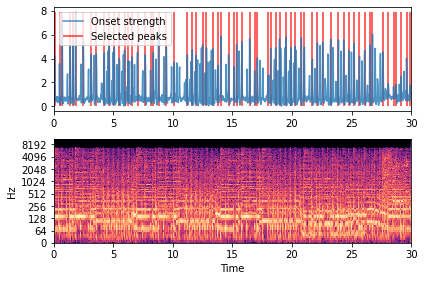

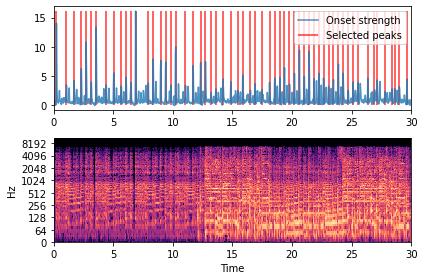

In [6]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    plot_spectrogram_and_peaks(track, sr, peaks, onset_env)

# 1.1 Preparing our dataset

<p>We create a dictionary "track_song" such that the keys are the indices of the songs and the values are the value_peaks of the corresponding song. <p>
<p>We create a list called "peak_1", in which we collect all the peak_value of the songs.<p>
<p>We create a dictionary called "titles" such that the keys are the indices of the songs and the values are the titles, we will use this dictionary after when matching the queries. <p>

In [7]:
track_song = dict()
peak_1 = list()
titles = dict()
for idx, audio in enumerate(tqdm(tracks)):
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    #to make the title equal to all.list
    audio = str(audio).replace("mp3s-32k\\", "").replace("\\", "/").replace(".wav", "")
    titles[idx] = audio
    for i in peaks:
        if idx not in track_song:
            track_song[idx] = [onset_env[i]]
        else:
            track_song[idx].append(onset_env[i])
        peak_1.append(onset_env[i])

# 1.2.1 Implement minhash from scratch

<p>-> We create the shingle matrix in which each row represents the  peak_value and each column represents a song, and the components of the matrix are equal to 1 if that  peak_value appears in the song, 0 otherwise. <p>

In [8]:
def create_shingle_matrix_track(peak, track_song):
    shingle_matrix = np.zeros([len(peak), len(track_song)])
    for row in tqdm(range(len(peak))):
        for col in track_song:
            num_col = int(str(col))
            if peak[row] in track_song[col]:
                shingle_matrix[row][num_col] = 1
    return shingle_matrix     

#### Hashing
<p>-> We will generate n (number of permutations of the rows of the matrix) hash functions whose basic form is: $f(x)=(ax+b^2)mod(r)$ where: x is the index of the row of the shingle_matrix, a and b are random numbers, pr is the nearest higher prime number to the number of songs. <p>

In [9]:
def get_hashed_rows(n, x, pr):
    random.seed(36)
    a, b, h = list(), list(), list()
    for i in range(n):
        a.append(random.randint(0, pr-1))
        b.append(random.randint(0, pr-1))
    for j in range(x):
            h.append([])
            for i in range(n):
                h[j].append((a[i]*j + b[i]**2) % pr) #this is where the hash functions are generated
    return h

- We create the signature matrix in which each row represents the hash function and each column represents a song. 
- We build the signature matrix in this way: we consider each shingle matrix row, we search for the column of that row that have value equal to 1. Then, only these columns of the signature matrix can change. If the column values of the signature matrix are bigger than the corresponding hash, we change the values in those columns. 

In [11]:
def create_signature_matrix(permutation, num_songs, shingle_matrix, hash_function):
    # initialize the signature matrix with all infinite values
    signature_matrix = np.ones([permutation, num_songs]) * np.inf
    for row in range(len(shingle_matrix)):
        idx = np.where(shingle_matrix[row]==1)[0]
        for i in idx:
            for h in range(len(hash_function[0])):
                # set the value of the signature matrix component to the corresponding hash value if the latter is smaller
                if signature_matrix[h][i] > hash_function[row][h]:
                    signature_matrix[h][i] = hash_function[row][h]
    return signature_matrix 

#### Bucket (from towards data science)
- Divide the signature matrix into 100 bands, each band having 5 rows
- For each band, hash its portion of each column to a hash table with k buckets: hash function we decided to use is $f(x)=(a*band+b^2)mod(r)$
- Candidate column pairs are those that hash to the same bucket for at least 1 band

In [12]:
# with this function we compute the hash of a band
def get_hash_band(band, pr):
    random.seed(36)
    a = random.randint(0, pr-1)
    b = random.randint(0, pr-1)
    h = ((np.multiply(band, a)) + b) % pr
    return h

In [13]:
def bucket(signature_matrix):
    bucket = dict()
    for song in range(len(signature_matrix[0])):
        for hashing in range(0, len(signature_matrix),5):
            band = list()
            # we are creating for each band, the portion of each column to hash 
            for c in range(5):
                b = signature_matrix[hashing+c][song]
                band.append(b)
            # we do the hash of that portion of the band
            h = get_hash_band(band, 1423)
            # if the hash is not in the bucket dictionary, we add it as a key and the value is the corresponding song 
            # if the hash is already in the bucket dictionary, then we simply add the song in the values of that hash
            if str(h.tolist()) not in bucket:
                bucket[str(h.tolist())] = set()
                bucket[str(h.tolist())].add(song)
            else:
                bucket[str(h.tolist())].add(song)
    return bucket  

# 1.2.2 Add the dataset to our minhash

In [14]:
num_songs = 1413
num_permutation = 500

In [15]:
shingle_matrix_track = create_shingle_matrix_track(peak_1, track_song)

In [16]:
#show the shingle_matrix of the dataset
print(shingle_matrix_track)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [17]:
hash_function = get_hashed_rows(num_permutation,shingle_matrix_track.shape[0],1423)

In [18]:
print(len(hash_function), len(hash_function[0]))

93647 500


In [19]:
#show the signature_matrix of the dataset
signature_matrix_track = create_signature_matrix(num_permutation, num_songs, shingle_matrix_track, hash_function)
print(signature_matrix_track)
print(signature_matrix_track.shape)

[[25.  5.  2. ...  9.  6.  0.]
 [13. 18. 28. ... 17. 27.  0.]
 [ 0. 10.  3. ...  8.  1. 11.]
 ...
 [23.  6. 14. ...  1.  9.  0.]
 [ 7. 20. 10. ... 28.  8. 21.]
 [ 4. 21.  1. ... 23.  3. 10.]]
(500, 1413)


In [20]:
#we then create the bucket_track dictionary in which the keys are the buckets and the values are the indices of the songs that
#are in that bucket.
bucket_track = bucket(signature_matrix_track)

# 1.2.3 Report the title of the query track

- First, we collect the queries in "query_track" dictionary, in which the keys are the numbers of the track of the queries and the values are the peak_values of the query.

In [21]:
data_folder_2 = Path("query_track/")
query = data_folder_2.glob("*.wav")

In [22]:
query_track = dict()
peak_2 = peak_1.copy()
for idx, audio in enumerate(tqdm(query)):
    query, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    for i in peaks:
        audio = str(audio).replace("query_track", "").replace("\\", "").replace(".wav", "")
        if audio not in query_track:
            query_track[audio] = [onset_env[i]]
        else:
            query_track[audio].append(onset_env[i])
        peak_2.append(onset_env[i])

<p>Then, we apply the same procedures to the queries, as we did with the dataset: by starting from the shingle matrix, then creating the signature matrix and after that we map the query to the k buckets.<p>
<p>We compute the similarity between the query and the songs that hash to the same bucket of the query for at least 1 band, the similarity score is given by: number of common components between the signature vector of the query and the signature vector of the song divided by the lenght of the song vector<p>
<p>We consider three different values of threshold and for each value we compute the LSH algorithm to find the title of the queries. We notice that for different values of threshold we can have different results, the most reliable ones are those corresponding to the threshold equal to 0.75<p>

In [23]:
def create_shingle_matrix_query(peak, song):
    shingle_matrix = np.zeros([len(peak), 1])
    for row in range(len(peak)):
        if peak[row] in song:
            shingle_matrix[row][0] = 1
    return shingle_matrix   

In [24]:
threshold = [0.25, 0.5, 0.75]
for tr in threshold:
    for song in query_track:
        #shingle of the query
        shingle_matrix_query = create_shingle_matrix_query(peak_2, query_track[song])     

        hash_function_query = get_hashed_rows(500,shingle_matrix_query.shape[0],1423)

        #signature of the query
        signature_matrix_query = create_signature_matrix(num_permutation, 1, shingle_matrix_query, hash_function_query)

        #bucket of the query
        bucket_query = list()
        for has in range(0, len(signature_matrix_query),5):
            band = list()
            for c in range(5):
                b = signature_matrix_query[has+c][0]
                band.append(b)
            h = get_hash_band(band, 1423)
            bucket_query.append(str(h.tolist()))

        #compute similarity
        score = dict()
        for bucket in bucket_query:
            if bucket in bucket_track:
                for k in bucket_track[bucket]:
                    #we compute the score by comparing the signature vector of the query and the signature vector of the song
                    #that has the common bucket with the query
                    sc = sum((signature_matrix_track[:, k])==(signature_matrix_query[:,0])) / (signature_matrix_track[:, k].shape[0])
                    if (titles[k] not in score) and (sc <= tr):
                        score[titles[k]] = sc
        if score != {}:
            #we take the title of the song with higher score
            score1 = sorted(score,key=score.get, reverse = True)
            print("the title of ", song, " is: ", score1[0], " for this threshold: ", tr)
        else:
            print("the code did not find any matching query for ", song, "according to this threshold: ", tr) 

the code did not find any matching query for  track1 according to this threshold:  0.25
the title of  track10  is:  fleetwood_mac/Mirage/12-Wish_You_Were_Here  for this threshold:  0.25
the title of  track2  is:  aerosmith/Rocks/07-Get_The_Lead_Out  for this threshold:  0.25
the title of  track3  is:  garth_brooks/Garth_Brooks_The_Limited_Series_/11-The_Dance  for this threshold:  0.25
the title of  track4  is:  u2/The_Joshua_Tree/04-Bullet_the_Blue_Sky  for this threshold:  0.25
the code did not find any matching query for  track5 according to this threshold:  0.25
the code did not find any matching query for  track6 according to this threshold:  0.25
the code did not find any matching query for  track7 according to this threshold:  0.25
the code did not find any matching query for  track8 according to this threshold:  0.25
the title of  track9  is:  creedence_clearwater_revival/Cosmo_s_Factory/02-Before_You_Accuse_Me  for this threshold:  0.25
the title of  track1  is:  green_day/Ins